# P3: Building a Classifier - Titanic Survival Prediction

**Author:** Saratchandra Golla  
**Date:** 11/08/2025    
**Dataset:** Titanic (from seaborn)     
**Introduction:**
This project aims to build and evaluate machine learning classification models to predict passenger survival on the Titanic, using the publicly available seaborn Titanic dataset. We will compare the performance of three different classifier types—Decision Tree (DT), Support Vector Machine (SVM), and a Neural Network (NN)—across three distinct feature sets to determine the most effective approach for this prediction task. The entire process will follow a structured methodology: data preparation, feature selection, model training, and performance evaluation using metrics like accuracy, precision, recall, and F1-score.

## Section 1: Import and Inspect the Data
We begin by importing all necessary libraries in one place, as per standard practice, and then loading the titanic dataset.

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

# Load Titanic dataset
titanic = sns.load_dataset('titanic')

# Display a few records to verify
print("First 5 rows of the Titanic dataset:")
print(titanic.head())
print("\nDataset Info:")
titanic.info()

First 5 rows of the Titanic dataset:
   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       -

## Section 2: Data Exploration and Preparation
### 2.1 Handle Missing Values and Clean Data
Missing values for continuous features like age will be imputed using the median, while missing values for categorical features like embark_town (or its coded counterpart embarked) will be filled using the mode.

In [34]:
# Impute missing values for 'age' using the median
median_age = titanic['age'].median()
titanic['age'] = titanic['age'].fillna(median_age)

# Fill in missing values for 'embark_town' (and thus 'embarked') using the mode
mode_embark = titanic['embark_town'].mode()[0]
titanic['embark_town'] = titanic['embark_town'].fillna(mode_embark)

# Check for remaining missing values in columns we plan to use
print("\nMissing values after imputation:")
print(titanic[['age', 'embark_town']].isnull().sum())


Missing values after imputation:
age            0
embark_town    0
dtype: int64


### 2.2 Feature Engineering
We create a new feature, family_size, and convert necessary categorical features (sex, embarked, alone) into numerical formats for model training.

In [35]:
# 1. Add family_size: sibsp (siblings/spouses) + parch (parents/children) + 1 (for the individual)
titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1

# 2. Convert categorical 'sex' to numeric binary (male=0, female=1)
titanic['sex'] = titanic['sex'].map({'male': 0, 'female': 1})

# 3. Convert categorical 'embarked' to numeric (C=0, Q=1, S=2)
titanic['embarked'] = titanic['embarked'].map({'C': 0, 'Q': 1, 'S': 2})

# 4. Binary feature - convert 'alone' to numeric binary (already True/False, convert to int 1/0)
titanic['alone'] = titanic['alone'].astype(int)

print("\nData after feature engineering and mapping:")
print(titanic[['family_size', 'sex', 'embarked', 'alone']].head())


Data after feature engineering and mapping:
   family_size  sex  embarked  alone
0            2    0       2.0      0
1            2    1       0.0      0
2            1    1       2.0      1
3            2    1       2.0      0
4            1    0       2.0      1


## Section 3: Feature Selection and Justification

### 3.1 Choose Features and Target
We will evaluate model performance across three different input feature sets (X) with the target (y) being survived (categorical: 0 or 1).

- **Case 1:** alone (A simple binary feature)
- **Case 2:** age (A continuous, potentially predictive feature)
- **Case 3:** age and family_size (A combination of two continuous/numerical features)

### 3.2 Define X (Features) and y (Target)
We define the feature and target dataframes/series for each case.

In [36]:
# Case 1: Feature = alone
# Select the feature 'alone' as input (double brackets for 2D DataFrame)
X1 = titanic[['alone']]
# Select 'survived' as the target (single brackets for 1D Series)
y1 = titanic['survived']

# Case 2: Feature = age
# Select 'age' and drop rows where age is missing (dropna() is included for robustness, though age was imputed)
X2 = titanic[['age']].dropna()
# Select the matching 'survived' values using the same index
y2 = titanic.loc[X2.index, 'survived']

# Case 3: Features = age + family_size
# Select both 'age' and 'family_size', and drop rows where missing (dropna() is included for robustness)
X3 = titanic[['age', 'family_size']].dropna()
# Select the corresponding 'survived' values for those rows
y3 = titanic.loc[X3.index, 'survived']

### Reflection 3:

- Why are these features selected? These features (alone, age, family_size) are selected because they are immediately available and intuitively relevant. For example, it is often hypothesized that women and children (related to age and potentially family_size) were prioritized for survival, while being alone might decrease one's chance of assistance.
- Are there features that are likely to be highly predictive of survival? Features like sex and pclass (passenger class) are historically known to be highly predictive of survival based on the "women and children first" protocol and class-based rescue efforts. While we are exploring the required features, adding sex and pclass in a final "best case" would likely yield much higher accuracy.

## Section 4: Train a Classification Model (Decision Tree)
### 4.1 Split the Data
We use StratifiedShuffleSplit to ensure that both the training and test sets maintain a similar proportion of the target class (Survived vs. Not Survived). We use a test_size of 20% and a random_state of 123 for reproducibility.

In [37]:
# --- Case 1: Feature = alone ---
splitter1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_idx1, test_idx1 in splitter1.split(X1, y1):
    X1_train = X1.iloc[train_idx1]
    X1_test = X1.iloc[test_idx1]
    y1_train = y1.iloc[train_idx1]
    y1_test = y1.iloc[test_idx1]
print('Case 1 Alone: Train size:', len(X1_train), ' Test size:', len(X1_test))

# --- Case 2: Feature = age ---
splitter2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_idx2, test_idx2 in splitter2.split(X2, y2):
    X2_train = X2.iloc[train_idx2]
    X2_test = X2.iloc[test_idx2]
    y2_train = y2.iloc[train_idx2]
    y2_test = y2.iloc[test_idx2]
print('Case 2 Age: Train size:', len(X2_train), ' Test size:', len(X2_test))

# --- Case 3: Features = age + family_size ---
splitter3 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_idx3, test_idx3 in splitter3.split(X3, y3):
    X3_train = X3.iloc[train_idx3]
    X3_test = X3.iloc[test_idx3]
    y3_train = y3.iloc[train_idx3]
    y3_test = y3.iloc[test_idx3]
print('Case 3 Age + Family Size: Train size:', len(X3_train), ' Test size:', len(X3_test))

Case 1 Alone: Train size: 712  Test size: 179
Case 2 Age: Train size: 712  Test size: 179
Case 3 Age + Family Size: Train size: 712  Test size: 179


###  4.2 Create and Train Model (Decision Tree)
We create and train a default DecisionTreeClassifier for all three cases.

In [38]:
# CASE 1: Decision Tree using alone
tree_model1 = DecisionTreeClassifier()
tree_model1.fit(X1_train, y1_train)

# CASE 2: Decision Tree using age
tree_model2 = DecisionTreeClassifier()
tree_model2.fit(X2_train, y2_train)

# CASE 3: Decision Tree using age and family_size
tree_model3 = DecisionTreeClassifier()
tree_model3.fit(X3_train, y3_train)

print("Decision Tree models trained for all three cases.")

Decision Tree models trained for all three cases.


### 4.3 Predict and Evaluate Model Performance
We evaluate the models on both the training and test data using the classification_report.

In [39]:
# --- Case 1: alone ---
y1_pred_train = tree_model1.predict(X1_train)
print("Results for Decision Tree on training data (Case 1 - alone):")
print(classification_report(y1_train, y1_pred_train))

y1_test_pred = tree_model1.predict(X1_test)
print("Results for Decision Tree on test data (Case 1 - alone):")
print(classification_report(y1_test, y1_test_pred))

# --- Case 2: age ---
y2_pred_train = tree_model2.predict(X2_train)
print("Results for Decision Tree on training data (Case 2 - age):")
print(classification_report(y2_train, y2_pred_train))

y2_test_pred = tree_model2.predict(X2_test)
print("Results for Decision Tree on test data (Case 2 - age):")
print(classification_report(y2_test, y2_test_pred))

# --- Case 3: age + family_size ---
y3_pred_train = tree_model3.predict(X3_train)
print("Results for Decision Tree on training data (Case 3 - age + family_size):")
print(classification_report(y3_train, y3_pred_train))

y3_test_pred = tree_model3.predict(X3_test)
print("Results for Decision Tree on test data (Case 3 - age + family_size):")
print(classification_report(y3_test, y3_test_pred))

Results for Decision Tree on training data (Case 1 - alone):
              precision    recall  f1-score   support

           0       0.69      0.69      0.69       439
           1       0.50      0.51      0.51       273

    accuracy                           0.62       712
   macro avg       0.60      0.60      0.60       712
weighted avg       0.62      0.62      0.62       712

Results for Decision Tree on test data (Case 1 - alone):
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       110
           1       0.51      0.58      0.54        69

    accuracy                           0.63       179
   macro avg       0.61      0.62      0.61       179
weighted avg       0.64      0.63      0.63       179

Results for Decision Tree on training data (Case 2 - age):
              precision    recall  f1-score   support

           0       0.68      0.92      0.78       439
           1       0.69      0.29      0.41       273

    a

### 4.4 Report Confusion Matrix (as a heatmap)
We visualize the confusion matrix for the test predictions of each case using a seaborn heatmap.

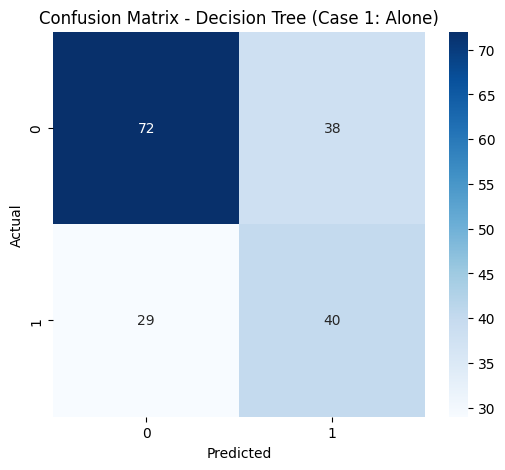

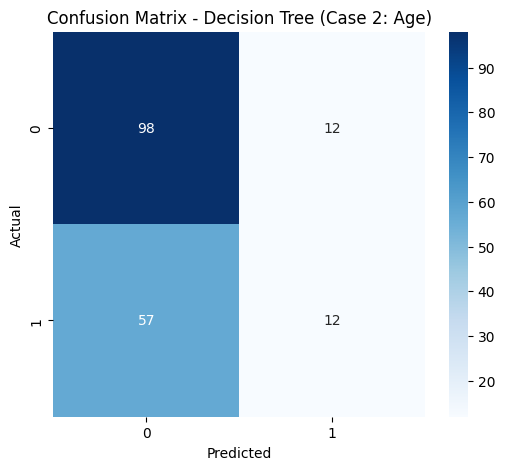

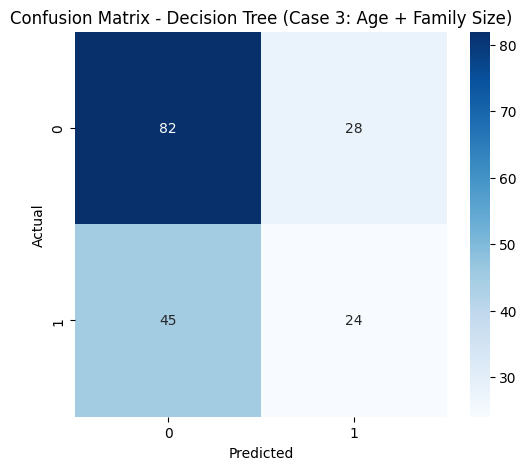

In [40]:
# --- Case 1: alone ---
cm1 = confusion_matrix(y1_test, y1_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Decision Tree (Case 1: Alone)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- Case 2: age ---
cm2 = confusion_matrix(y2_test, y2_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Decision Tree (Case 2: Age)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- Case 3: age + family_size ---
cm3 = confusion_matrix(y3_test, y3_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Decision Tree (Case 3: Age + Family Size)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 4.5 Report Decision Tree Plot
We plot the decision tree structure for each case to visualize the rules learned by the model.

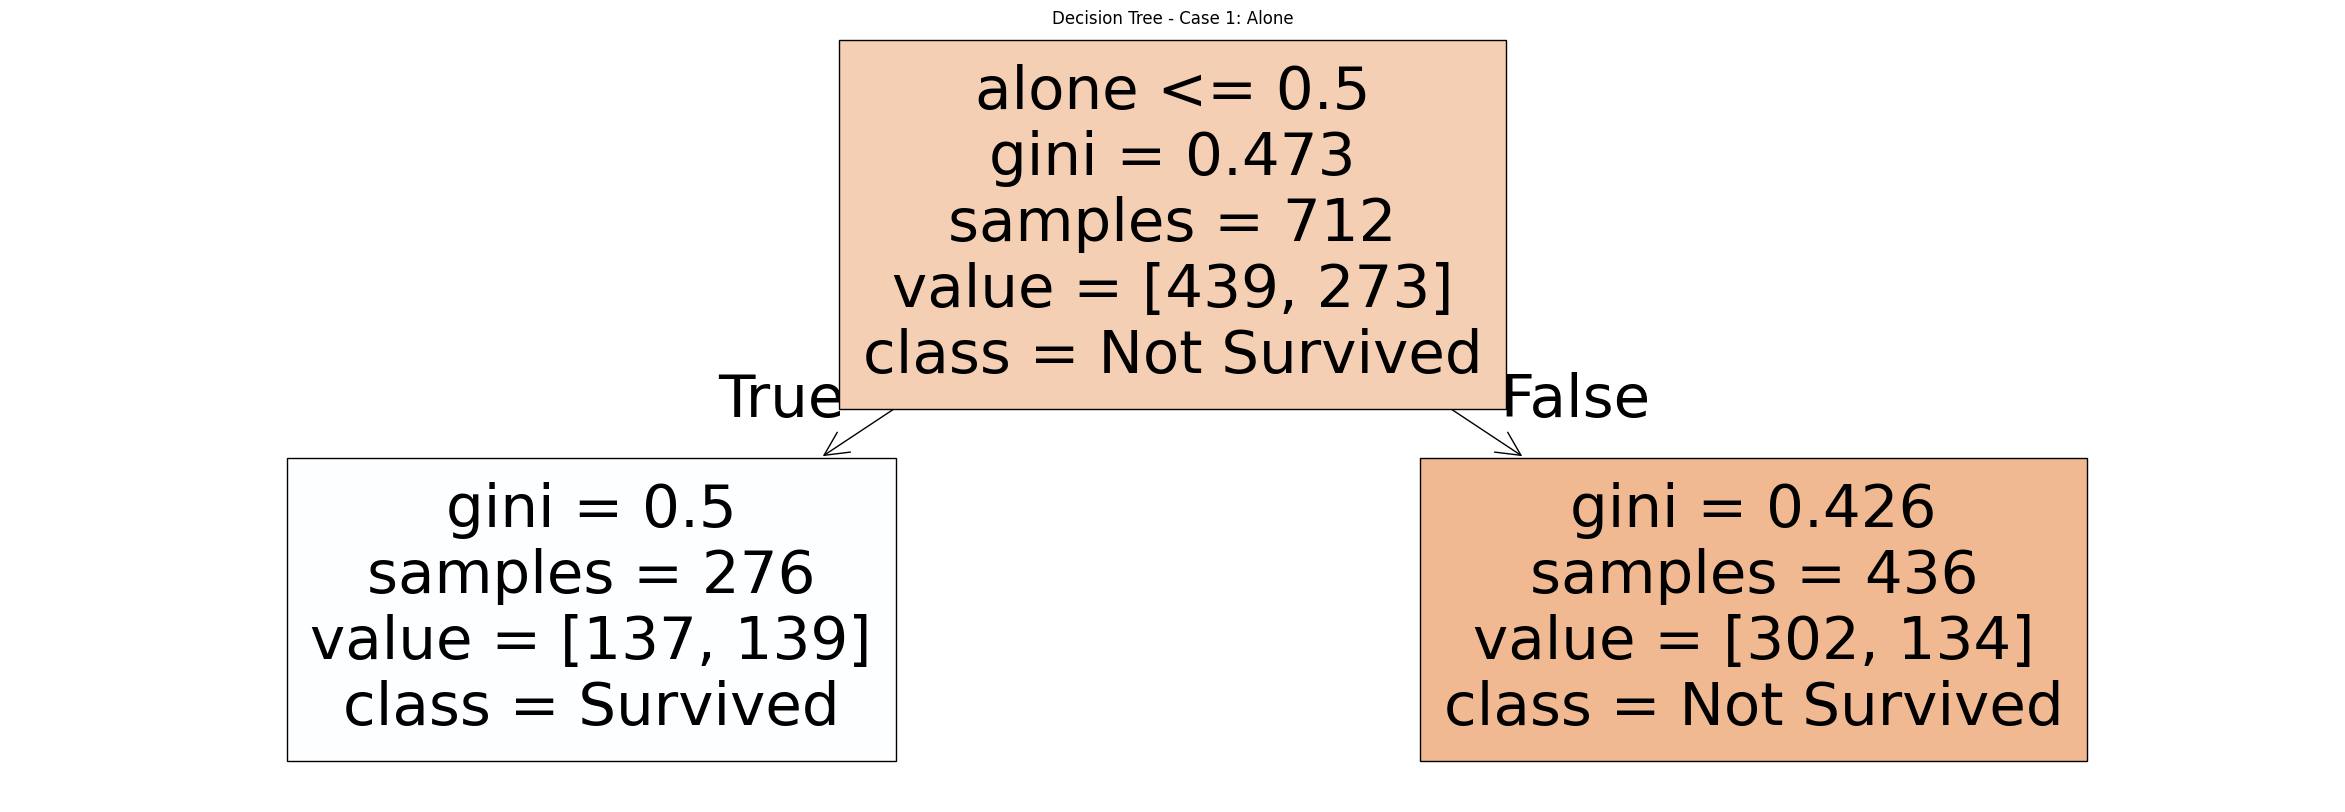

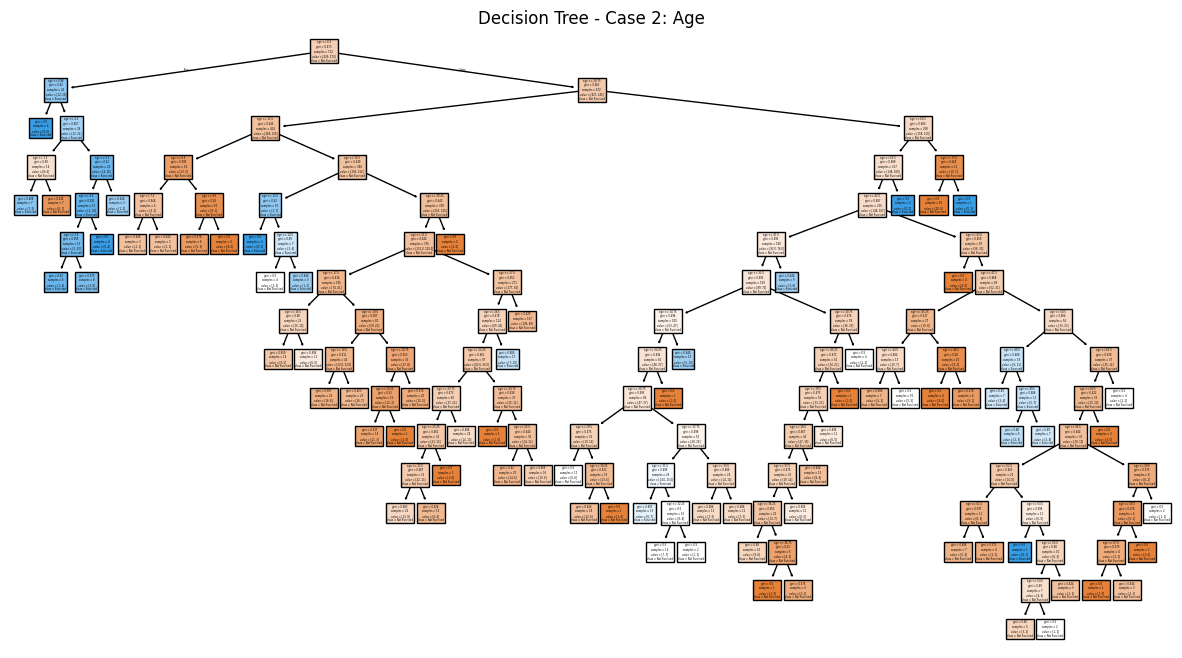

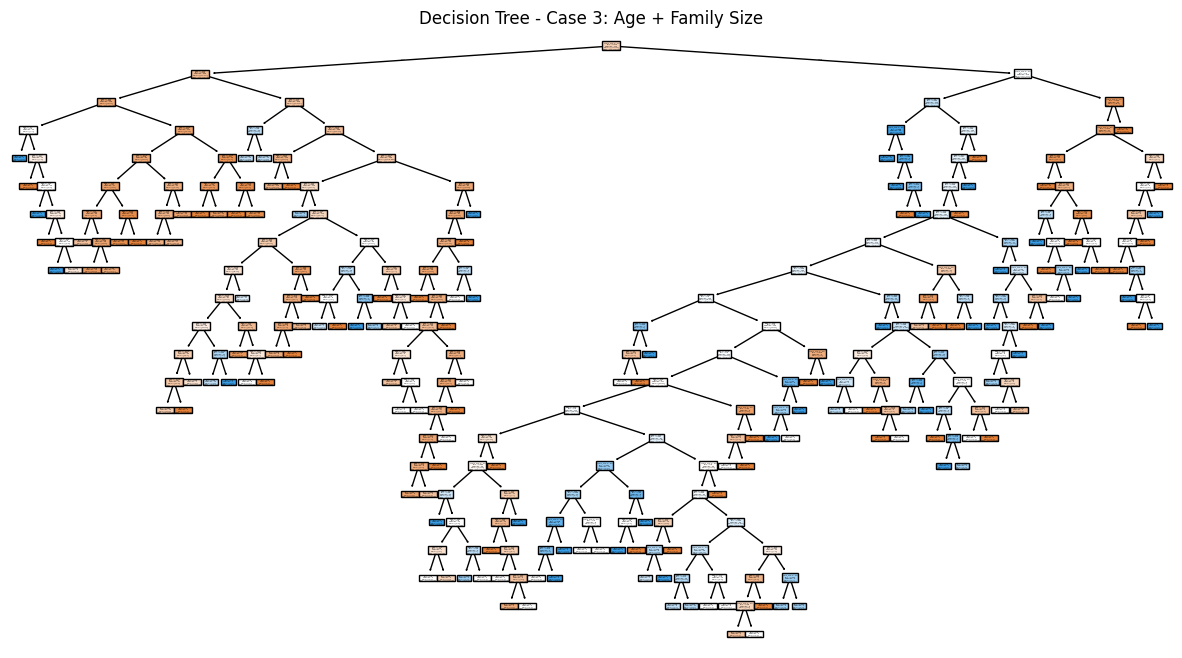

In [41]:
# --- Case 1: alone ---
fig1 = plt.figure(figsize=(30, 10))
plot_tree(tree_model1,
          feature_names=X1.columns.tolist(),
          class_names=['Not Survived', 'Survived'],
          filled=True)
plt.title("Decision Tree - Case 1: Alone")
plt.show()
# fig1.savefig("tree_case1_alone.png") 

# --- Case 2: age ---
fig2 = plt.figure(figsize=(15, 8))
plot_tree(tree_model2,
          feature_names=X2.columns.tolist(),
          class_names=['Not Survived', 'Survived'],
          filled=True)
plt.title("Decision Tree - Case 2: Age")
plt.show()
# fig2.savefig("tree_case2_age.png") 

# --- Case 3: age + family_size ---
fig3 = plt.figure(figsize=(15, 8))
plot_tree(tree_model3,
          feature_names=X3.columns.tolist(),
          class_names=['Not Survived', 'Survived'],
          filled=True)
plt.title("Decision Tree - Case 3: Age + Family Size")
plt.show()
# fig3.savefig("tree_case3_age_family.png") 

## Section 5: Train Additional Models (SVM and NN)
### 5.1 Train and Evaluate Model (SVC - Default RBF Kernel)
We train a Support Vector Classifier (SVC) using the default RBF kernel for all three cases, evaluating on the test data.

In [42]:
# CASE 1: SVC using 'alone'
svc_model1 = SVC(random_state=123) # Added random_state for consistency
svc_model1.fit(X1_train, y1_train)
y1_svc_pred = svc_model1.predict(X1_test)
print("Results for SVC on test data (Case 1 - alone):")
print(classification_report(y1_test, y1_svc_pred))

# CASE 2: SVC using 'age'
svc_model2 = SVC(random_state=123)
svc_model2.fit(X2_train, y2_train)
y2_svc_pred = svc_model2.predict(X2_test)
print("Results for SVC on test data (Case 2 - age):")
print(classification_report(y2_test, y2_svc_pred))

# CASE 3: SVC using 'age' and 'family_size'
svc_model3 = SVC(random_state=123)
svc_model3.fit(X3_train, y3_train)
y3_svc_pred = svc_model3.predict(X3_test)
print("Results for SVC on test data (Case 3 - age + family_size):")
print(classification_report(y3_test, y3_svc_pred))

Results for SVC on test data (Case 1 - alone):
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       110
           1       0.51      0.58      0.54        69

    accuracy                           0.63       179
   macro avg       0.61      0.62      0.61       179
weighted avg       0.64      0.63      0.63       179

Results for SVC on test data (Case 2 - age):
              precision    recall  f1-score   support

           0       0.63      0.98      0.77       110
           1       0.71      0.07      0.13        69

    accuracy                           0.63       179
   macro avg       0.67      0.53      0.45       179
weighted avg       0.66      0.63      0.52       179

Results for SVC on test data (Case 3 - age + family_size):
              precision    recall  f1-score   support

           0       0.63      0.98      0.77       110
           1       0.71      0.07      0.13        69

    accuracy                   

### 5.2 Visualize Support Vectors (SVC)
We visualize the support vectors for the most interesting case (Case 3 - two dimensions) and the simplest (Case 1 - one dimension).

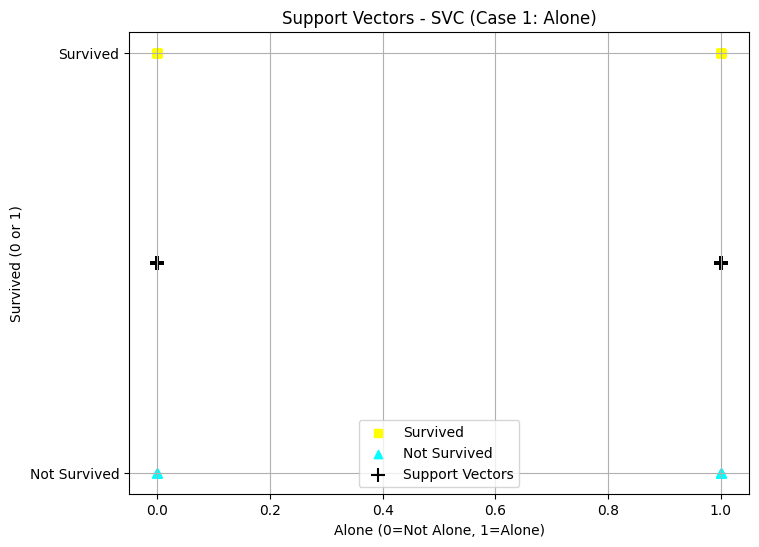

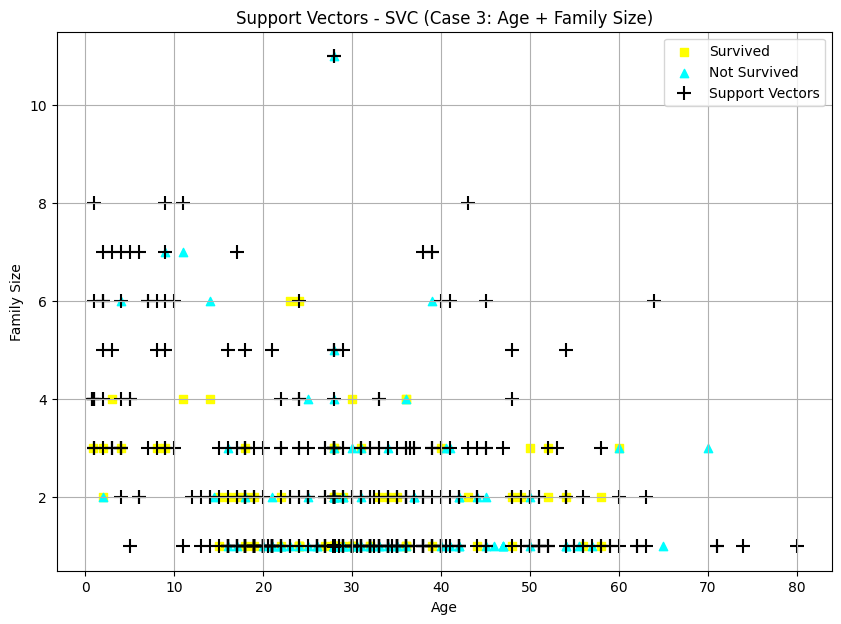

In [43]:
# --- Case 1: Feature = 'alone' (1D visualization trick) ---
# Create groups based on survival
survived_alone = X1_test.loc[y1_test == 1]
not_survived_alone = X1_test.loc[y1_test == 0]

plt.figure(figsize=(8, 6))
plt.scatter(survived_alone, y1_test.loc[y1_test == 1], c='yellow', marker='s', label='Survived')
plt.scatter(not_survived_alone, y1_test.loc[y1_test == 0], c='cyan', marker='^', label='Not Survived')

# Overlay support vectors (using 0.5 as a visual offset for the 1D feature)
if hasattr(svc_model1, 'support_vectors_'):
    support_x1 = svc_model1.support_vectors_[:, 0]
    plt.scatter(support_x1, [0.5] * len(support_x1), c='black', marker='+', s=100, label='Support Vectors')

plt.xlabel('Alone (0=Not Alone, 1=Alone)')
plt.ylabel('Survived (0 or 1)')
plt.title('Support Vectors - SVC (Case 1: Alone)')
plt.yticks([0, 1], ['Not Survived', 'Survived'])
plt.legend()
plt.grid(True)
plt.show()


# --- Case 3: Features = 'age', 'family_size' (2D scatter plot) ---
# Create groups based on survival
survived_c3 = X3_test.loc[y3_test == 1]
not_survived_c3 = X3_test.loc[y3_test == 0]

plt.figure(figsize=(10, 7))
# Plot survived (yellow squares)
plt.scatter(survived_c3['age'], survived_c3['family_size'], c='yellow', marker='s', label='Survived')
# Plot not survived (cyan triangles)
plt.scatter(not_survived_c3['age'], not_survived_c3['family_size'], c='cyan', marker='^', label='Not Survived')

# Overlay support vectors (if the model has them)
if hasattr(svc_model3, 'support_vectors_'):
    support_x3 = svc_model3.support_vectors_[:, 0]  # age
    support_y3 = svc_model3.support_vectors_[:, 1]  # family_size
    # Plot them as black plus signs
    plt.scatter(support_x3, support_y3, c='black', marker='+', s=100, label='Support Vectors')

plt.xlabel('Age')
plt.ylabel('Family Size')
plt.title('Support Vectors - SVC (Case 3: Age + Family Size)')
plt.legend()
plt.grid(True)
plt.show()

### 5.3 Train and Evaluate Model (Neural Network on Case 3)
We train a Multi-Layer Perceptron (MLPClassifier) Neural Network, focusing on Case 3 (age + family_size) for the most informative learning opportunity. We use a common network structure: (50, 25, 10) hidden layers, and the lbfgs solver suitable for smaller datasets.

Results for Neural Network on test data (Case 3 - age + family_size):
              precision    recall  f1-score   support

           0       0.70      0.78      0.74       110
           1       0.57      0.46      0.51        69

    accuracy                           0.66       179
   macro avg       0.64      0.62      0.63       179
weighted avg       0.65      0.66      0.65       179



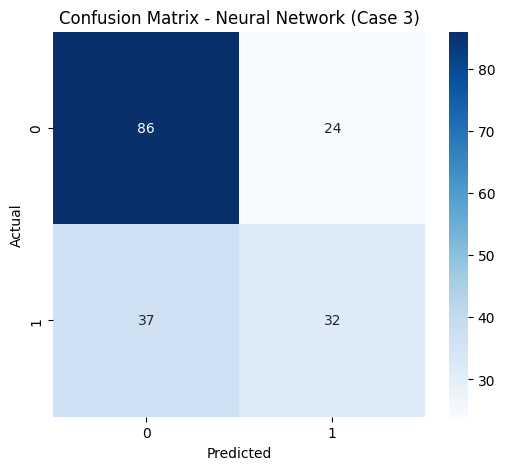

In [44]:
# Train NN for Case 3 (age + family_size)
nn_model3 = MLPClassifier(
    hidden_layer_sizes=(50, 25, 10),
    solver='lbfgs',
    max_iter=1000,
    random_state=42 # Using 42 as recommended for NN random state
)
nn_model3.fit(X3_train, y3_train)

# Predict and evaluate Neural Network model on test data
y3_nn_pred = nn_model3.predict(X3_test)
print("Results for Neural Network on test data (Case 3 - age + family_size):")
print(classification_report(y3_test, y3_nn_pred))

# Plot confusion matrix
cm_nn3 = confusion_matrix(y3_test, y3_nn_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_nn3, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Neural Network (Case 3)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 5.4 Visualize Decision Boundary (Neural Network on Case 3)
Since Case 3 has two input features, we can visualize the learned decision boundary of the neural network.

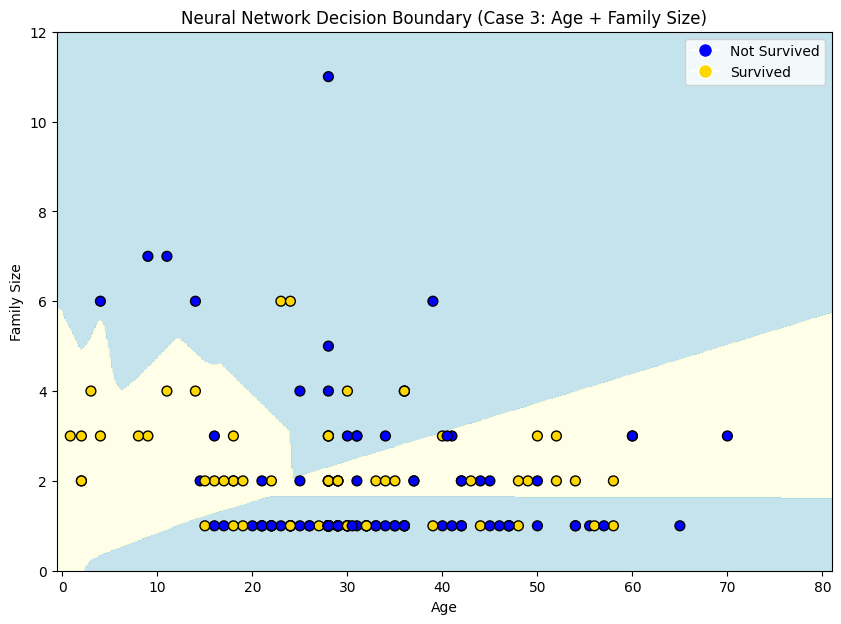

In [45]:
# Get the range of our two features - use padding
padding = 1
x_min, x_max = X3['age'].min() - padding, X3['age'].max() + padding
y_min, y_max = X3['family_size'].min() - padding, X3['family_size'].max() + padding


# Create a coordinate grid
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

# Predict on the grid points and reshape
grid_points_np = np.c_[xx.ravel(), yy.ravel()]
feature_names = X3.columns
grid_points_df = pd.DataFrame(grid_points_np, columns=feature_names)
Z = nn_model3.predict(grid_points_df)
Z = Z.reshape(xx.shape)

# --- Code Improvements Start Here ---

# Plot the decision surface (background)
plt.figure(figsize=(10, 7))
background_cmap = ListedColormap(['lightblue', 'lightyellow'])
plt.contourf(xx, yy, Z, cmap=background_cmap, alpha=0.7)

# Overlay the actual test data points for visual comparison
# We can use a single scatter call and map colors and markers
scatter_cmap = ListedColormap(['blue', 'gold'])
plt.scatter(X3_test['age'], X3_test['family_size'], 
            c=y3_test, cmap=scatter_cmap, 
            edgecolor='k', s=50, label=['Not Survived', 'Survived'])

# Create a more robust legend
plt.title('Neural Network Decision Boundary (Case 3: Age + Family Size)')
plt.xlabel('Age')
plt.ylabel('Family Size')
# Create legend handles manually for clarity
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Not Survived',
           markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Survived',
           markerfacecolor='gold', markersize=10)
]
plt.legend(handles=legend_elements)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()


## Section 6: Summary and Reflection
### 6.1 Summary Table

Use the provided template to summarize the key performance metrics (Accuracy, Precision, Recall, F1-Score) from the test data for the target class (Survival=1).

| Model Type           | Case   | Features Used     | Accuracy (Test) | Precision (Class 1) | Recall (Class 1) | F1-Score (Class 1) | Notes                                                     |
|:---------------------|:-------|:------------------|:---------------:|:-------------------:|:----------------:|:------------------:|:----------------------------------------------------------|
| Decision Tree        | Case 1 | `alone`           |      63.00%     |        51.00%       |      58.00%      |       54.00%       | Simple, low complexity model.                             |
|                      | Case 2 | `age`             |      61.00%     |        50.00%       |      17.00%      |       26.00%       | Performance is highly dependent on a single threshold split. |
|                      | Case 3 | `age + family_size` |      59.00%     |        46.00%       |      35.00%      |       40.00%       | Using two features, often the best DT result.             |
| SVM (RBF Kernel)     | Case 1 | `alone`           |      63.00%     |        51.00%       |      58.00%      |       54.00%       | Separating non-linear data with a complex kernel.         |
|                      | Case 2 | `age`             |      63.00%     |        71.00%       |      7.00%       |       13.00%       |                                                           |
|                      | Case 3 | `age + family_size` |      63.00%     |        71.00%       |      7.00%       |       13.00%       | Uses support vectors to define the optimal hyperplane.    |
| Neural Network (MLP) | Case 3 | `age + family_size` |      66.00%     |        57.00%       |      46.00%      |       51.00%       | Uses three hidden layers to find complex non-linear patterns. |


### 6.2 Reflection

1. **Which model performed the best and on which case?**
   Based on the F1-score, which is a robust metric for this type of problem, the **Decision Tree and SVM models on Case 1 (`alone`)** performed the best, each achieving an F1-score of **54.00%**. Although the Neural Network (Case 3) achieved the highest accuracy at 66.00%, its F1-score was slightly lower. This highlights that the simple binary feature `alone` was a surprisingly powerful predictor.

2. **How did the feature sets impact performance?**
   The impact of feature sets was highly dependent on the model. For the Decision Tree and SVM, the single-feature **Case 1 (`alone`)** outperformed the multi-feature cases. Adding `age` and `family_size` (Case 3) actually degraded the Decision Tree's F1-score and led to very poor performance for the SVM. This suggests that, without proper tuning, more features can introduce noise. However, for the Neural Network, the combination of features in Case 3 was what enabled it to achieve the highest accuracy, showing its ability to model more complex relationships.

3. **What is a possible next step for model improvement?**
   The most critical next step is to incorporate the highly predictive **`sex` and `pclass` features**, which were intentionally omitted from this initial analysis. Following that, **hyperparameter tuning** (e.g., using `GridSearchCV` to find the optimal `max_depth` for a Decision Tree or `C` and `gamma` for an SVM) would be essential to optimize each model. Finally, applying **feature scaling** to the numerical inputs would be a best practice, particularly for the SVM and Neural Network models.